In [1]:
import os
import numpy
from numpy.matlib import repmat
import numpy as np 
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import math
import open3d as o3d

from PIL import Image
from tqdm import tqdm_notebook

In [2]:
depth_path = "/Users/shashanks./Desktop/_out/depth/030510.png"
semantic_path = "/Users/shashanks./Desktop/_out/ss/030510.png"

#### Display depth and semantic segmentation

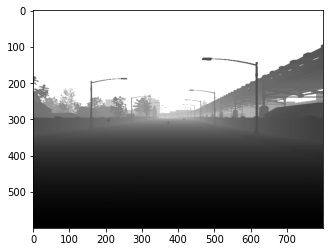

In [3]:
depth_img = Image.open(depth_path)
plt.imshow(depth_img, cmap='gray')

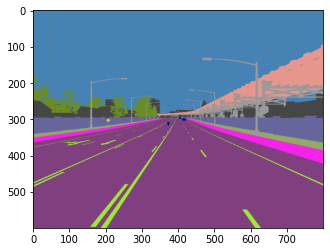

In [4]:
semantic_img = Image.open(semantic_path)
plt.imshow(semantic_img)

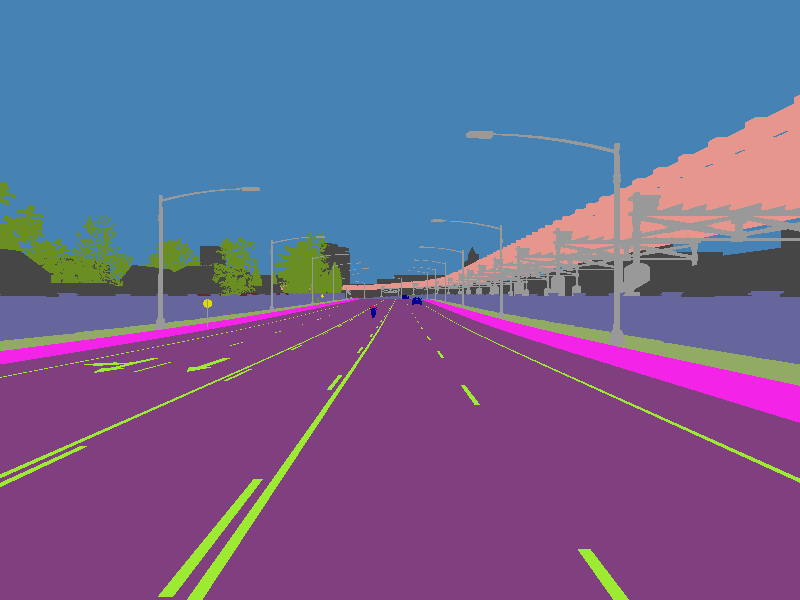

In [16]:
semantic_img

### Helper functions

In [5]:
def depth_to_image(img_path):
    # Read the image 
    im = cv2.imread(img_path, 1) # Color image
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB) # Convert from BGR to RGB
    im = im.astype(np.int32)
    
    # Convert to normalized depth
    normalized_depth = im[:, :, 0] + (im[:, :, 1] * 256) + (im[:, :, 2] * 256 * 256)
    normalized_depth = normalized_depth.astype(np.double)
    normalized_depth = normalized_depth / ((256 * 256 * 256) - 1)
    return normalized_depth

#### Display normalized depth image

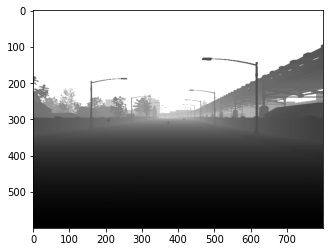

In [6]:
depth_img_normalized = depth_to_image(depth_path)
plt.imshow(depth_img_normalized, cmap='gray')

#### Camera Parameters

In [7]:
fov = 90.0
img_width, img_height = 800, 600
f = img_width / (2.0 * math.tan(fov * math.pi / 360.0))

#### Depth to point cloud

In [8]:
def depth_to_local_point_cloud(img_path, fov):
    far = 1000.0
    normalized_depth = depth_to_image(img_path)
    
    # K Matrix (Intrinsic)
    k = np.identity(3)
    k[0, 2] = img_width / 2.0
    k[1, 2] = img_height / 2.0
    k[0, 0] = k[1, 1] = f
    
    pixel_length = img_width * img_height
    u = repmat(numpy.r_[img_width - 1: -1: -1], img_height, 1).reshape(pixel_length)
    v = repmat(numpy.c_[img_height - 1: -1: -1], 1, img_width).reshape(pixel_length)
    
    # 2d points in homogenous coordinates [u, v, 1]
    p2d = np.array([u, v, np.ones_like(u)])
    
    # 3d points [X, Y, Z]
    p3d = np.dot(numpy.linalg.inv(k), p2d) * (normalized_depth.reshape(pixel_length) * far)
    p3d = p3d.T
    return p3d

In [9]:
pcloud = depth_to_local_point_cloud(depth_path, fov)
# Pass xyz to Open3D.o3d.geometry.PointCloud and visualize
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pcloud)
o3d.io.write_point_cloud("pcloud.ply", pcd)

True

In [10]:
# Load saved point cloud and visualize it
pcd_load = o3d.io.read_point_cloud("pcloud.ply")
o3d.visualization.draw_geometries([pcd_load])

#### Convert to cityscapes palette

In [ ]:
def label_to_cityscapes_palette(img_path):
    classes = {
        0: [0, 0, 0],        # None
        1: [70, 70, 70],     # Buildings
        2: [190, 153, 153],  # Fences
        3: [72, 0, 90],      # Other
        4: [220, 20, 60],    # Pedestrians
        5: [153, 153, 153],  # Poles
        6: [157, 234, 50],   # RoadLines
        7: [128, 64, 128],   # Roads
        8: [244, 35, 232],   # Sidewalks
        9: [107, 142, 35],   # Vegetation
        10: [0, 0, 255],     # Vehicles
        11: [102, 102, 156], # Walls
        12: [220, 220, 0]    # TrafficSigns
    }

    # Read the image 
    im = cv2.imread(img_path, 1) # Color image
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB) # Convert from BGR to RGB
    
    array = im[:, :, 0] # Consider only the red class
    res = np.zeros((array.shape[0], array.shape[1], 3)) # Initialize the cityscapes image
    for key, value in classes.items():
        res[np.where(array == key)] = value
    
    return res

#### Get masked points

In [11]:
def getMaskedPoints(img_path, p3d, channel):
    # Read the image 
    im = cv2.imread(img_path, 1) # Color image
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB) # Convert from BGR to RGB

    array = im[:, :, 0].reshape(-1) # Consider only the red class

    if channel == "lane":
        mask_array = (array == 157) # Create a binary mask
    elif channel == "road":
        mask_array = (array == 128) # Create a binary mask
    else:
        mask_array = ((array != 0) & (array != 157) & (array != 128) & (array != 10)) # Create a binary mask
    
    #if channel == "lane":
    #    mask_array = (array == 6) # Create a binary mask
    #elif channel == "road":
    #    mask_array = (array == 7) # Create a binary mask
    #else:
    #    mask_array = ((array != 0) & (array != 6) & (array != 7) & (array != 10)) # Create a binary mask
    mask_3d = p3d[mask_array, :] # Select only the rows that we are interested in
    return mask_3d

In [12]:
road_3d = getMaskedPoints(semantic_path, pcloud, "road")
# Pass xyz to Open3D.o3d.geometry.PointCloud and visualize
pcd_road = o3d.geometry.PointCloud()
pcd_road.points = o3d.utility.Vector3dVector(road_3d)
o3d.io.write_point_cloud("road_3d.ply", pcd_road)

True

In [13]:
# Load saved point cloud and visualize it
pcd_road_load = o3d.io.read_point_cloud("road_3d.ply")
o3d.visualization.draw_geometries([pcd_road_load])

In [14]:
lane_3d = getMaskedPoints(semantic_path, pcloud, "lane")
# Pass xyz to Open3D.o3d.geometry.PointCloud and visualize
pcd_lane = o3d.geometry.PointCloud()
pcd_lane.points = o3d.utility.Vector3dVector(lane_3d)
o3d.io.write_point_cloud("lane_3d.ply", pcd_lane)

True

In [15]:
# Load saved point cloud and visualize it
pcd_lane_load = o3d.io.read_point_cloud("lane_3d.ply")
o3d.visualization.draw_geometries([pcd_lane_load])

#### Occupancy grid initializations

In [ ]:
size_x = 240 # 30m in left or right of vehicle
size_z = 400 # 100m in fron of vehicle
unknown_prob_value = 0.0
known_prob_value = 1.0

# Rows represent the Z, Columns represent the X
# Change in Z value is along the columns, Change in X values is along the rows

grid_center = [size_x / 2, 0]
cell_size = 0.25

x_min = - np.floor((size_x - 1) / 2)
x_max = np.floor((size_x - 1) / 2)

In [ ]:
def get_masked_occupancy_grid(mask_3d):
    occ_grid = np.zeros((size_x, size_z))
    for i in range(mask_3d.shape[0]):
        X = np.round(mask_3d[i, 0] / cell_size)
        Z = np.round(mask_3d[i, 2] / cell_size)
        if Z > 0:
            if X >= x_min and X <= x_max and Z < size_z:
                X = int(X + grid_center[0])
                Z = int(Z)
                occ_grid[X, Z] = known_prob_value
    
    return occ_grid

In [ ]:
def gen_occ_grid(depth_path, semantics_path, channel):
    p3d = depth_to_local_point_cloud(depth_path, fov=fov)
    mask_3d = getMaskedPoints(semantics_path, p3d, channel)
    occ_grid = get_masked_occupancy_grid(mask_3d)
    return occ_grid

#### Testing

In [ ]:
road_occ_grid = gen_occ_grid(depth_path, semantic_path, "road")
lane_occ_grid = gen_occ_grid(depth_path, semantic_path, "lane")
obstacle_occ_grid = gen_occ_grid(depth_path, semantic_path, "obstacle")

In [ ]:
plt.imshow(road_occ_grid, cmap="gray")
plt.show()

In [ ]:
np.sum(road_occ_grid)

In [ ]:
plt.imshow(lane_occ_grid, cmap="gray")
plt.show()

#### Data reading and writing

In [ ]:
dataset_dir = "/Users/shashanks./Desktop/_out/rgb/"
depth_dir = "/Users/shashanks./Desktop/_out/depth/"
semantics_dir = "/Users/shashanks./Desktop/_out/ss/"
channels = ["lane", "road", "obstacles"]

In [ ]:
for trajectory_dir in tqdm_notebook(sorted(os.listdir(depth_dir))):
    trajectory_path = os.path.join(depth_dir, trajectory_dir)
    for filename in sorted(os.listdir(trajectory_path)):
        depth_path = os.path.join(trajectory_path, filename)
        semantics_path = os.path.join(semantics_dir, trajectory_dir, filename)
        
        for channel in channels:
            channel_dir = os.path.join(dataset_dir, channel, trajectory_dir)
            os.makedirs(channel_dir, exist_ok=True)            
            occ_grid_path = os.path.join(channel_dir, filename)
            occ_grid = gen_occ_grid(depth_path, semantics_path, channel=channel)
            
            occ_grid = occ_grid * 255.0
            im = Image.fromarray(occ_grid).convert('L')
            im.save(occ_grid_path)

In [ ]:
occ_grid = gen_occ_grid(depth_path, semantics_path, channel="lane")
plt.imshow(occ_grid, cmap="gray")
plt.show()